In [ ]:
# Mengunduh dataset yang tersimpan di dalam Google Drive
# Dataset diunduh dari Kaggle (https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)
!gdown --id 1gP2tiJx3eTJFPIJJKoOsVUcbWb-0irWe

Downloading...
From: https://drive.google.com/uc?id=1gP2tiJx3eTJFPIJJKoOsVUcbWb-0irWe
To: /content/Dataset Submission 1.zip
100% 738k/738k [00:00<00:00, 47.1MB/s]


In [ ]:
# Mengekstrak file .zip
import zipfile
import os
local_zip = '/content/Dataset Submission 1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data = pd.read_csv('/content/train.txt', names=['sentence', 'label'], sep=';')
train_data.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train_data['label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [ ]:
test_data = pd.read_csv('/content/test.txt', names=['sentence', 'label'], sep=';')
test_data.head()

,sentence,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
test_data['label'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64

In [ ]:
# Karena label 'surprise' memiliki jumlah sampel yang jauh lebih sedikit dibandingkan dengan label lainnya,
# label tersebut dihapus untuk menghindari underfit model pada label 'surprise'
surprise_index = train_data[train_data['label']=='surprise'].index
train_data.drop(surprise_index, inplace=True)
surprise_index = test_data[test_data['label']=='surprise'].index
test_data.drop(surprise_index, inplace=True)

In [ ]:
train_data['label'].value_counts()

joy        5362
sadness    4666
anger      2159
fear       1937
love       1304
Name: label, dtype: int64

In [ ]:
test_data['label'].value_counts()

joy        695
sadness    581
anger      275
fear       224
love       159
Name: label, dtype: int64

In [ ]:
# Fungsi untuk menghapus stop words pada dataset
stop_words = set(stopwords.words('english'))
def remove_stopwords(data):
  for index in range(len(data)):
    for word in stop_words:
      token = " " + word + " "
      sentence = data['sentence'].values[index]
      sentence = sentence.replace(token, " ")
      data['sentence'].values[index] = sentence

In [ ]:
remove_stopwords(train_data)
remove_stopwords(test_data)

In [ ]:
# Menggabungkan data latih dan data uji ke dalam satu dataframe
# Untuk mempermudah pembagian proporsi data uji dan data latih
merged_data = pd.concat([train_data, test_data])

In [ ]:
# Membuat one-hot-encoding label
category = pd.get_dummies(merged_data.label)
merged_data = pd.concat([merged_data, category], axis=1)
merged_data = merged_data.drop(columns='label')
merged_data.head()

,sentence,anger,fear,joy,love,sadness
0,i didnt feel humiliated,0,0,0,0,1
1,i go feeling hopeless damned hopeful around so...,0,0,0,0,1
2,im grabbing minute post feel greedy wrong,1,0,0,0,0
3,i ever feeling nostalgic fireplace know still ...,0,0,0,1,0
4,i feeling grouchy,1,0,0,0,0


In [ ]:
sentence = merged_data['sentence'].values
label = merged_data[['anger', 'fear', 'joy', 'love', 'sadness']].values

training_sentence, testing_sentence, training_label, testing_label = train_test_split(sentence, label, test_size=0.2)

In [ ]:
vocab_size = 10000
embedding_dim = 16
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentence)
tokenizer.fit_on_texts(testing_sentence)

train_sequences = tokenizer.texts_to_sequences(training_sentence)
train_sequences = pad_sequences(train_sequences)

test_sequences = tokenizer.texts_to_sequences(testing_sentence)
test_sequences = pad_sequences(test_sequences)

In [ ]:
# Membuat dan mengkompilasi model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [ ]:
# Detail arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 181,061
Trainable params: 181,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Membuat callback untuk memberhentikan pelatihan model ketika target akurasi tercapai
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc') > 0.91) and (logs.get('val_acc') > 0.91):
            print("\nDesired accuracy (91%) reached.")
            self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# Melatih model
history = model.fit(
    train_sequences,
    training_label,
    epochs=200,
    validation_data=(test_sequences, testing_label),
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/200
435/435 - 8s - loss: 1.1975 - acc: 0.5152 - val_loss: 0.7144 - val_acc: 0.7662
Epoch 2/200
435/435 - 5s - loss: 0.4186 - acc: 0.8691 - val_loss: 0.3303 - val_acc: 0.8854
Epoch 3/200
435/435 - 5s - loss: 0.1471 - acc: 0.9537 - val_loss: 0.2609 - val_acc: 0.9093
Epoch 4/200
435/435 - 5s - loss: 0.0808 - acc: 0.9751 - val_loss: 0.2794 - val_acc: 0.9044
Epoch 5/200
435/435 - 5s - loss: 0.0569 - acc: 0.9820 - val_loss: 0.2610 - val_acc: 0.9153

Desired accuracy (91%) reached.


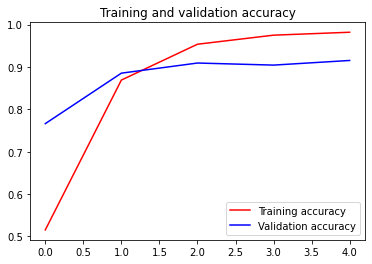

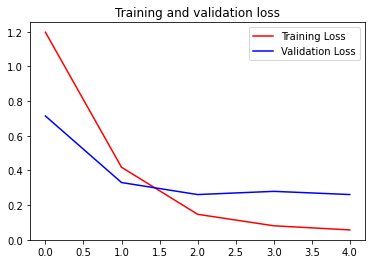

In [ ]:
# Membuat plot loss dan akurasi pada proses latihan dan validasi
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()